---

- il faut d'abord trouver le model de forme minimal qui est capable d'overfit (grosso modo combien de couche de conv et combien de filtre par conv)
- puis il trouver les paramètres optimaux avec le tuner à hyperbande
- puis entrainer notre modèle sur un très grand nombre d'epoch pour voir quand il overfit (optimisation de l'epoch)
- enfin entrainer le modèle final et afficher les images avec prédicition correcte

---

- meilleurs résultats avec naif et data augmenté : val_accuracy = 0.9152 à l'epoch 112
- en optimissant tout les paramètres possible on peu espérer essayer de dépasser 0.96 (c'est l'objectif que je me fixe en tout cas)

---

In [ ]:
# Importing working libraries
import os
import sys
import cv2
import json
import shutil
import random
import pickle
import librosa
import requests
import datetime
import math as m
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import librosa.display
import tensorflow as tf
from pathlib import Path
from keras import optimizers
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Rescaling, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

# Checking that we are using the GPUs correctly
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Select your development environment
environment = "Google Colab" # "Google Colab", "Local"

# Loading depending on environment
project_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  project_path = "/content/drive/MyDrive/Colab Notebooks/Personal Project/Cat and Dog Classification"
else:
  project_path = "./"

# Image folder manager
images_original = os.path.join(project_path,"dataset","dataset")
images_dataset = os.path.join(project_path,"dataset")
images_dataset_train = os.path.join(images_dataset,"train")
images_dataset_validation = os.path.join(images_dataset,"validation")
images_dataset_test = os.path.join(images_dataset,"test")

# Check the existence
os.makedirs(images_dataset_train, exist_ok=True)
os.makedirs(images_dataset_validation, exist_ok=True)
os.makedirs(images_dataset_test, exist_ok=True)
os.makedirs(os.path.join(project_path,"models"), exist_ok=True)

Found GPU at: /device:GPU:0
Num GPUs Available:  1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Splitting images_original to create images_dataset

# # Proportions
# proportion_train = 0.8
# proportion_validation = 0.1
# proportion_test = 0.1

# # Iterate through each class folder
# for classe in os.listdir(images_original):
#     classe_path = os.path.join(images_original, classe)
#     if os.path.isdir(classe_path):
#         images = os.listdir(classe_path)
#         random.shuffle(images)

#         # Divide the images into training, validation, and test sets
#         num_images = len(images)
#         num_train = int(num_images * proportion_train)
#         num_validation = int(num_images * proportion_validation)

#         train_images = images[:num_train]
#         validation_images = images[num_train:num_train + num_validation]
#         test_images = images[num_train + num_validation:]

#         # Copy the images to the respective folders
#         for image in train_images:
#             src = os.path.join(classe_path, image)
#             dest = os.path.join(images_dataset, "train", classe, image)
#             os.makedirs(os.path.dirname(dest), exist_ok=True)
#             shutil.copy(src, dest)

#         for image in validation_images:
#             src = os.path.join(classe_path, image)
#             dest = os.path.join(images_dataset, "validation", classe, image)
#             os.makedirs(os.path.dirname(dest), exist_ok=True)
#             shutil.copy(src, dest)

#         for image in test_images:
#             src = os.path.join(classe_path, image)
#             dest = os.path.join(images_dataset, "test", classe, image)
#             os.makedirs(os.path.dirname(dest), exist_ok=True)
#             shutil.copy(src, dest)

In [ ]:
# Data preparation

batch_size = 30
img_height = 256
img_width = 256
input_shape=(img_width,img_height,3)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  images_dataset_train,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  images_dataset_validation,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  images_dataset_test,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

class_names = train_data.class_names
num_classes = len(class_names)
print("Class names : ",class_names)
print("Number of classes : ",num_classes)
print("Number of classes in train dataset : ",len(train_data.class_names))
print("Number of classes in validation dataset : ",len(val_data.class_names))
print("Number of classes in test dataset : ",len(test_data.class_names))

Found 8020 files belonging to 2 classes.
Found 1002 files belonging to 2 classes.
Found 1005 files belonging to 2 classes.
Class names :  ['cat', 'dog']
Number of classes :  2
Number of classes in train dataset :  2
Number of classes in validation dataset :  2
Number of classes in test dataset :  2


In [ ]:
import matplotlib.pyplot as plt

# Fonction pour afficher les images avec labels catégoriels
def show_images_categorical(dataset, class_names):
    plt.figure(figsize=(15, 15))

    for images, labels in dataset.take(1):  # Prend les premières images du dataset
        for i in range(10):  # Affiche 10 images
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Trouve l'index du label catégoriel avec la valeur 1
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")

# Obtention des noms de classe à partir du dataset d'entraînement
class_names = train_data.class_names

# Affichage des images pour chaque ensemble de données
show_images_categorical(train_data, class_names)
plt.suptitle("Images d'entraînement")
plt.show()

show_images_categorical(val_data, class_names)
plt.suptitle("Images de validation")
plt.show()

show_images_categorical(test_data, class_names)
plt.suptitle("Images de test")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # import numpy as np
# # from sklearn.model_selection import GridSearchCV
# # !pip install scikeras
# # from scikeras.wrappers import KerasClassifier
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Dense
# # import tensorflow as tf
# # from tensorflow.keras import layers

# # Model creation

# num_classes = 2

# # Fonction pour créer un modèle TensorFlow
# # def create_model(input_shape,num_classes,kernel_size,nb_con,dropout,learning_rate,
# #                  hidden_layer_activation_functions,final_layer_activation_functions):
# def create_model(kernel_size,nb_con,dropout,learning_rate,hidden_layer_activation_functions,final_layer_activation_functions):
#   # Construction du modèle en fonction des paramètres
#   model = tf.keras.models.Sequential([
#       layers.Rescaling(1./255, input_shape=input_shape),
#       layers.Conv2D(nb_con, kernel_size, activation=hidden_layer_activation_functions),
#       layers.MaxPooling2D(),
#       layers.Conv2D(nb_con*2, kernel_size, activation=hidden_layer_activation_functions),
#       layers.MaxPooling2D(),
#       layers.Conv2D(nb_con*4, kernel_size, activation=hidden_layer_activation_functions),
#       layers.Flatten(),
#       layers.Dropout(dropout),
#       layers.Dense(num_classes, activation=final_layer_activation_functions)
#   ])
#   # Compilez le modèle avec les hyperparamètres
#   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])

#   return(model)


# # Créer le modèle KerasClassifier pour scikit-learn
# model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

# # Définir les hyperparamètres à rechercher
# param_grid = {
#     'kernel_size': [(3, 3), (5, 5)],  # Taille du noyau pour Conv2D
#     'nb_con': [32, 48, 64, 80, 96],  # Nombre de filtres pour la première couche convolutive
#     'dropout': [0.3, 0.5, 0.7],  # Taux de dropout
#     'learning_rate': [0.001, 0.01, 0.1],  # Taux d'apprentissage
#     'hidden_layer_activation_functions': ['relu', 'tanh', 'sigmoid'],  # Fonctions d'activation pour les layers cachés
#     'final_layer_activation_functions': ['sigmoid', 'softmax']  # Fonctions d'activation pour le layer de sortie
# }

# # Créer l'objet GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# train_data_numpy = np.array(list(train_data.as_numpy_iterator()))
# val_data_numpy = np.array(list(val_data.as_numpy_iterator()))

# # Ajuster le modèle avec la recherche par grille
# grid_result = grid.fit(
#       train_data_numpy, #train_data,
#       validation_data=val_data_numpy, #val_data,
#       workers=10,
#       epochs=15,
# )

# # Afficher les résultats
# print("Meilleurs hyperparamètres trouvés : ", grid_result.best_params_)
# print("Meilleur score d'exactitude : ", grid_result.best_score_)

In [ ]:
# Il existe trois types de technique :
#     - Grid Search (la recherche en grille)
#     - Random Search (la recherche aleatoire)
#     - L’optimisation bayésienne, Hyperbande (techniques plus sophistiquées)

# j'ai tenté avec GridSearchCV de scikeras : from scikeras.wrappers import KerasClassifier
# mais cela ne semble pas très pratique et adpater
# on va donc directement utiliser le tuner keras qui est basé sur l’optimisation bayésienne, Hyperbande

In [ ]:
# Constructeur de modèle

def model_builder(hp): # num_filters, kernel_size, units (number of units in Dense layer), dropout, learning_rate
  # Création du modèle
  model = keras.Sequential()
  # Rescaling
  model.add(Rescaling(1./255, input_shape=input_shape)),
  # Tune the number of filters for the third and fourth Conv2D
  # Choose an optimal value from 64-128
  hp_filters = hp.Choice('num_filters', values=[64, 128], default=64)
  # Tune the kernel size for the second Conv2D
  # Choose an optimal value from 3x3 or 5x5
  hp_kernel_size = hp.Choice('kernel_size', values=[3,5], default=3)
  # ---- Conv / Pool N°1
  model.add(Conv2D(filters=64, kernel_size=(hp_kernel_size,hp_kernel_size), strides=1, padding='valid', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
  # ---- Conv / Pool N°2
  model.add(Conv2D(filters=64, kernel_size=(hp_kernel_size,hp_kernel_size), strides=1, padding='valid', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
  # ---- Conv / Pool N°3
  model.add(Conv2D(filters=hp_filters, kernel_size=(hp_kernel_size,hp_kernel_size), strides=1, padding='valid', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
  # ---- Conv / Pool N°4
  model.add(Conv2D(filters=hp_filters, kernel_size=(hp_kernel_size,hp_kernel_size), strides=1, padding='valid', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
  # Fully Connected
  # Flattening : passage de matrices 3D vers un vecteur
  model.add(Flatten())
  # Tune the number of units in Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation='relu'))
  # Tune the Dropout
  # Choose an optimal value between 0.1-0.5
  hp_dropout = hp.Float("dropout", min_value=0.1, max_value=0.5, default=0.25, step=0.05)
  model.add(Dropout(rate=hp_dropout))
  # Couche de sortie : classification => softmax sur le nombre de classe
  model.add(Dense(units=num_classes, activation='softmax'))
  # compilation du model de classification
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
  # Retourner le model
  return(model)

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=15,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='cat_or_dog')

# # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # EARLY_STOPPING = EarlyStopping(monitor='val_loss', patience=STOPPING_PATIENCE, verbose=VERBOSE, mode='auto')
# # LR_REDUCTION = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=VERBOSE, factor=0.5, min_lr=0.00001)
# # CALLBACKS = [EARLY_STOPPING, LR_REDUCTION]

# # EARLY_STOPPING = EarlyStopping(monitor='val_loss', patience=5)
# # LR_REDUCTION = ReduceLROnPlateau(monitor='val_acc', patience=5, factor=0.5, min_lr=0.00001)
# # CALLBACKS = [EARLY_STOPPING, LR_REDUCTION]

# EARLY_STOPPING = EarlyStopping(monitor='val_loss', patience=5)
# LR_REDUCTION = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, min_lr=0.00001)
# CALLBACKS = [EARLY_STOPPING, LR_REDUCTION]

# tuner.search(
#     train_data,
#     validation_data = val_data,
#     epochs=50,
#     callbacks=CALLBACKS
# )

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete:
# - The optimal number of convolution filters in the third and fourth convolution layers is {best_hps.get('num_filters')}.
# - The optimal kernel size in convolution layers is {best_hps.get('kernel_size')}.
# - The optimal number of units in the densely connected layer is {best_hps.get('units')}.
# - The optimal dropout is {best_hps.get('dropout')}.
# - The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)

# print(best_hps.get_config())

Trial 30 Complete [00h 03m 00s]
val_accuracy: 0.7095808386802673

Best val_accuracy So Far: 0.8233532905578613
Total elapsed time: 00h 42m 07s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.001.



---

Trial 30 Complete [00h 03m 00s]

val_accuracy: 0.7095808386802673

Best val_accuracy So Far: 0.8233532905578613

Total elapsed time: 00h 42m 07s

---

The hyperparameter search is complete:
- The optimal number of convolution filters in the third and fourth convolution layers is 128.
- The optimal kernel size in convolution layers is 3.
- The optimal number of units in the densely connected layer is 320.
- The optimal dropout is 0.4.
- The optimal learning rate for the optimizer is 0.001.

---

{'space': [{'class_name': 'Choice', 'config': {'name': 'num_filters', 'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'kernel_size', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.25, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}], 'values': {'num_filters': 128, 'kernel_size': 3, 'units': 320, 'dropout': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}}

---

In [ ]:
# # Sauvegarder tout l'objet best_hps dans un fichier
# best_hyperparameters_file = os.path.join(project_path, "models", f"best_hyperparameters.pkl")
# with open(best_hyperparameters_file, 'wb') as file:
#     pickle.dump(best_hps, file)

In [ ]:
# Sauvegarde du tuner -> pas possible
# donc on va juste sauvegarder toute les config
# Sauvegarder la configuration du tuner dans un fichier
tuner_config = tuner.get_config()
config_file_path = os.path.join(project_path, "models", "tuner_config.pkl")
with open(config_file_path, 'wb') as config_file:
    pickle.dump(tuner_config, config_file)

AttributeError: ignored

In [ ]:
# Charger tout l'objet best_hps dans une variable
best_hyperparameters_file = os.path.join(project_path, "models", f"best_hyperparameters.pkl")
with open(best_hyperparameters_file, 'rb') as file:
    loaded_best_hps = pickle.load(file)

In [ ]:
print(f"""
The hyperparameter search is complete:
- The optimal number of convolution filters in the third and fourth convolution layers is {loaded_best_hps.get('num_filters')}.
- The optimal kernel size in convolution layers is {loaded_best_hps.get('kernel_size')}.
- The optimal number of units in the densely connected layer is {loaded_best_hps.get('units')}.
- The optimal dropout is {loaded_best_hps.get('dropout')}.
- The optimal learning rate for the optimizer is {loaded_best_hps.get('learning_rate')}.
""")

print(loaded_best_hps.get_config())


The hyperparameter search is complete:
- The optimal number of convolution filters in the third and fourth convolution layers is 128.
- The optimal kernel size in convolution layers is 3.
- The optimal number of units in the densely connected layer is 320.
- The optimal dropout is 0.4.
- The optimal learning rate for the optimizer is 0.001.

{'space': [{'class_name': 'Choice', 'config': {'name': 'num_filters', 'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'kernel_size', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.25, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'def

In [ ]:
# Reconstruire le tuner dans le cas ou on ne l'a pas entrainé précédement
loaded_tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='my_dir',
                     project_name='cat_or_dog')

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = loaded_tuner.hypermodel.build(loaded_best_hps)

EARLY_STOPPING = EarlyStopping(monitor='val_loss', patience=5)
LR_REDUCTION = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, min_lr=0.00001)
CALLBACKS = [EARLY_STOPPING, LR_REDUCTION]

history = model.fit(
    train_data,
    validation_data = val_data,
    epochs=100,
    callbacks=CALLBACKS
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Reloading Tuner from my_dir/cat_or_dog/tuner0.json
Epoch 1/100
268/268 [==============================] - 15s 47ms/step - loss: 0.9610 - accuracy: 0.6550 - val_loss: 1.8580 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
268/268 [==============================] - 13s 46ms/step - loss: 0.5280 - accuracy: 0.7410 - val_loss: 0.6255 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 3/100
268/268 [==============================] - 13s 47ms/step - loss: 0.4703 - accuracy: 0.7835 - val_loss: 0.5500 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 4/100
268/268 [==============================] - 13s 47ms/step - loss: 0.4049 - accuracy: 0.8212 - val_loss: 0.5502 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 5/100
268/268 [==============================] - 13s 47ms/step - loss: 0.3325 - accuracy: 0.8570 - val_loss: 0.5184 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 6/100
268/268 [==============================] - 13s 46ms/step - loss: 0.2676 - accuracy: 0.8901 - val_loss: 0.5462 - val_accuracy: 0.7784 - lr: 0.0010
E

Reloading Tuner from my_dir/cat_or_dog/tuner0.json
Epoch 1/100
268/268 [==============================] - 15s 47ms/step - loss: 0.9610 - accuracy: 0.6550 - val_loss: 1.8580 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
268/268 [==============================] - 13s 46ms/step - loss: 0.5280 - accuracy: 0.7410 - val_loss: 0.6255 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 3/100
268/268 [==============================] - 13s 47ms/step - loss: 0.4703 - accuracy: 0.7835 - val_loss: 0.5500 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 4/100
268/268 [==============================] - 13s 47ms/step - loss: 0.4049 - accuracy: 0.8212 - val_loss: 0.5502 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 5/100
268/268 [==============================] - 13s 47ms/step - loss: 0.3325 - accuracy: 0.8570 - val_loss: 0.5184 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 6/100
268/268 [==============================] - 13s 46ms/step - loss: 0.2676 - accuracy: 0.8901 - val_loss: 0.5462 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 7/100
268/268 [==============================] - 13s 47ms/step - loss: 0.2024 - accuracy: 0.9191 - val_loss: 0.6253 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 8/100
268/268 [==============================] - 13s 46ms/step - loss: 0.1478 - accuracy: 0.9434 - val_loss: 0.5977 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 9/100
268/268 [==============================] - 13s 47ms/step - loss: 0.1171 - accuracy: 0.9556 - val_loss: 0.5801 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 10/100
268/268 [==============================] - 13s 46ms/step - loss: 0.0834 - accuracy: 0.9716 - val_loss: 0.6101 - val_accuracy: 0.8004 - lr: 0.0010
Best epoch: 10

---

le modèle overfit -> complexité de mon model trop élévé et/ou pas assez de données d'entrainement -> je pourrais entrainer avec les data augmenté mais j'ai plus trop de crédit donc on verra plus tard, j'ai compris le principe c'est le principale

---

In [ ]:
# model_tuner = model
# history_model_tuner = history

# Sauvegarder le modèle
template_file_model_tuner = os.path.join(project_path, "models", f"model_tuner")
model.save(template_file_model_tuner)

# Sauvegarder l'historique
history_file_model_tuner = os.path.join(project_path, "models", f"history_model_tuner.pkl")
with open(history_file_model_tuner, 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# Charger les modèles
template_file_model_tuner = os.path.join(project_path, "models", f"model_tuner")
loaded_model = load_model(template_file_model_tuner)

# Charger les historiques
history_file_model_tuner = os.path.join(project_path, "models", f"history_model_tuner.pkl")
with open(history_file_model_tuner, 'rb') as file:
    loaded_history = pickle.load(file)

In [ ]:
def plot_history(history, model_name):
    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']

    plt.figure(figsize=(12, 6))

    for i in range(2):  # Deux graphiques (accuracy et loss)
        plt.subplot(1, 2, i + 1)
        metric_name = metrics[i*2]
        val_metric_name = metrics[i*2 + 1]

        metric_values = history[metric_name] #.history[metric_name]
        val_metric_values = history[val_metric_name] #.history[val_metric_name]

        epochs = range(len(metric_values))

        plt.plot(epochs, metric_values, label=f'Training {metric_name.capitalize()}')
        plt.plot(epochs, val_metric_values, label=f'Validation {metric_name.capitalize()}')
        plt.title(f'{model_name} : Training and Validation {metric_name.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

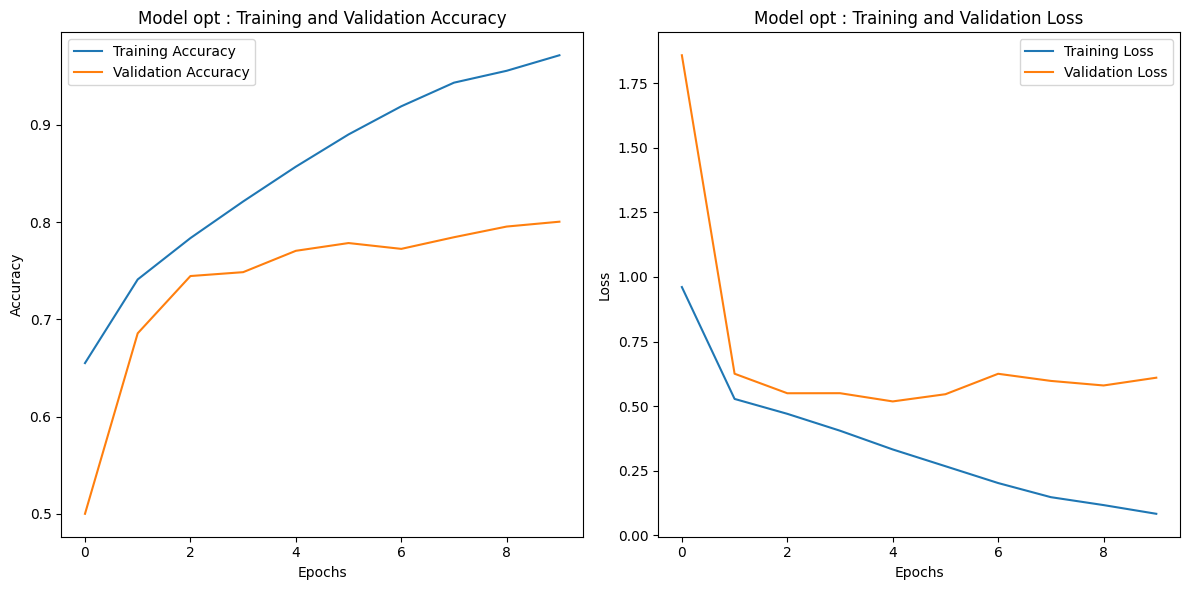

In [ ]:
# print(loaded_history)
plot_history(loaded_history, "Model opt")

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss_1, test_accuracy_1 = model_1.evaluate(test_data)
print(f'-> Model 1 - Test Accuracy: {test_accuracy_1}, Test Loss: {test_loss_1}')
test_loss_2, test_accuracy_2 = model_2.evaluate(test_data)
print(f'-> Model 2 - Test Accuracy: {test_accuracy_2}, Test Loss: {test_loss_2}')

34/34 [==============================] - 1s 22ms/step - loss: 0.4166 - accuracy: 0.8119
-> Model 1 - Test Accuracy: 0.8119403123855591, Test Loss: 0.4166207015514374
34/34 [==============================] - 1s 23ms/step - loss: 0.4357 - accuracy: 0.8179
-> Model 2 - Test Accuracy: 0.8179104328155518, Test Loss: 0.4357052147388458


In [ ]:
# Data augmentation

# On définit nos paramètres d'augmentation de données
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

# On applique l'augmentation des données (seulement sur le training set)
augmented_train_data  = train_data.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# Model creation

num_classes = 2

model_1 = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(128,4,input_shape=input_shape,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2 = keras.models.Sequential([
    layers.Rescaling(1./255),
    keras.layers.Conv2D(24, 5, input_shape=input_shape, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(48, 5, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(96, 5, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_classes, activation='softmax')
])

# model.build((None,) + input_shape)
# model.summary()

model_1.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_2.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
history_1_augm = model_1.fit(
    augmented_train_data,
    validation_data = val_data,
    workers=10,
    epochs=40,
)

history_2_augm = model_2.fit(
    augmented_train_data,
    validation_data = val_data,
    workers=10,
    epochs=40,
)

Epoch 1/40
268/268 [==============================] - 165s 611ms/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6895 - val_accuracy: 0.5729
Epoch 2/40
268/268 [==============================] - 164s 611ms/step - loss: 0.6827 - accuracy: 0.5547 - val_loss: 0.6597 - val_accuracy: 0.6028
Epoch 3/40
268/268 [==============================] - 162s 602ms/step - loss: 0.6625 - accuracy: 0.5958 - val_loss: 0.6315 - val_accuracy: 0.6377
Epoch 4/40
268/268 [==============================] - 161s 600ms/step - loss: 0.6356 - accuracy: 0.6398 - val_loss: 0.5979 - val_accuracy: 0.6796
Epoch 5/40
268/268 [==============================] - 160s 595ms/step - loss: 0.6225 - accuracy: 0.6536 - val_loss: 0.6049 - val_accuracy: 0.6727
Epoch 6/40
268/268 [==============================] - 160s 595ms/step - loss: 0.6104 - accuracy: 0.6728 - val_loss: 0.5845 - val_accuracy: 0.6607
Epoch 7/40
268/268 [==============================] - 163s 609ms/step - loss: 0.5969 - accuracy: 0.6858 - val_loss: 0.5599 -

In [ ]:
# Sauvegarder les modèles
template_file_1_augm = os.path.join(project_path, "models", f"model_1_augm")
model_1.save(template_file_1_augm)
template_file_2_augm = os.path.join(project_path, "models", f"model_2_augm")
model_2.save(template_file_2_augm)

# Sauvegarder les historiques
history_file_1_augm = os.path.join(project_path, "models", f"history_1_augm.pkl")
with open(history_file_1_augm, 'wb') as file:
    pickle.dump(history_1_augm.history, file)
history_file_2_augm = os.path.join(project_path, "models", f"history_2_augm.pkl")
with open(history_file_2_augm, 'wb') as file:
    pickle.dump(history_2_augm.history, file)

In [ ]:
# Charger les modèles
template_file_1_augm = os.path.join(project_path, "models", f"model_1_augm")
model_1 = load_model(template_file_1_augm)
template_file_2_augm = os.path.join(project_path, "models", f"model_2_augm")
model_2 = load_model(template_file_2_augm)

# Charger les historiques
history_file_1_augm = os.path.join(project_path, "models", f"history_1_augm.pkl")
with open(history_file_1_augm, 'rb') as file:
    loaded_history_1_augm = pickle.load(file)
history_file_2_augm = os.path.join(project_path, "models", f"history_2_augm.pkl")
with open(history_file_2_augm, 'rb') as file:
    loaded_history_2_augm = pickle.load(file)

In [ ]:
plot_history(history_1, "Model 1 Augmenté")
plot_history(history_2, "Model 2 Augmenté")